### Notebook to run association analyses for HBN sample.
- Author: Dominik Kraft

- make sure to use correct conda environment or use __conda activate net_fusion__ before starting the jupyter notebook

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [451]:
##  seaborn settings 
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='helvetica',
    font_scale=1,
    color_codes=True,
    rc=None)

In [312]:
def partial_eta_square(model):
    """
    Function to calculate partial eta square from OLS model after fitting
    ---
    Input:
    - sm.model object after fitting the model
    ----
    Output:
    - no return value, but prints partial eta squares for each predictor in model
    """
    
    # transform model to anova table
    anova_table = sm.stats.anova_lm(model) 
    # index of anova table = predictor list
    predictors = anova_table.index.to_list()
    
    # exclude categorical predictors + residuals
    to_exclude = ("C(", "Resi")
    predictors = [p for p in predictors if not p.startswith(to_exclude)]
    
    #iterate over all predictors and calculate eta squared 
    for predictor in predictors:
        SS_predictor = anova_table.loc[predictor, 'sum_sq']
        SS_resid = anova_table.loc['Residual', 'sum_sq']
        partial_eta_squared = SS_predictor / (SS_predictor + SS_resid)
        print(f'Partial eta squared for {predictor}: {partial_eta_squared.round(5)}')

In [314]:
dic = np.load('../outputs/outputdict_hbn.npy',allow_pickle='TRUE').item()
# load output from main_hbn.py



##### integrating information about primary diagnosis

In [455]:
# load info about DX and perform same data handling
#change path to file
dx = pd.read_csv("9994_ConsensusDx_20220818.csv",
                 sep=",",
        usecols=["DX_01", "DX_01_Cat", "EID"],
        skiprows=[1],
    )

dx.rename(columns={"EID": "subjectkey"}, inplace=True)

# rename subjects
dx["subjectkey"] = [
    "sub-" + x for x in dx["subjectkey"].str.replace(",assessment", "")
]

dx = dx.drop_duplicates(subset=["subjectkey"])
dx.dropna(inplace=True)

dx.isnull().sum()

subjectkey    0
DX_01_Cat     0
DX_01         0
dtype: int64

In [464]:
demos = dic["demos"][1]
demos = demos.loc[~demos["DX_01"].isin(
            ["No Diagnosis Given", "No Diagnosis Given: Incomplete Eval"]
        )]
print(demos.shape) # excludes one subject that was erroneously still in in the dx group despite having no diagnosis

tt = demos.merge(dx, on="subjectkey", how="left") ### take care of missing vakues


(2271, 16)


###### the following cells map the primary diagnosis to six disorders (see paper for details)

In [465]:
### after these adjustments, there are several subjects with NaN in DX_cat despite having information in DX_01_x
tt.DX_01_Cat = tt.apply(lambda row: "ADHD" if row['DX_01_x'].startswith('ADHD') else row['DX_01_Cat'], axis=1)
tt.DX_01_Cat = tt.apply(lambda row: "ASD" if row['DX_01_x'] == "Autism Spectrum Disorder" else row['DX_01_Cat'], axis=1)
tt.DX_01_Cat = tt.apply(lambda row: "Anxiety Disorders" if "Anxiety" in row['DX_01_x'] else row['DX_01_Cat'], axis=1)

In [466]:
# this issue can be solved by applying this intermediate mapping to DX_01_x

intermediate_mapping= {
    'Oppositional Defiant Disorder': 'Disruptive, Impulse Control and Conduct Disorders',
    'Speech Sound Disorder': 'Neurodevelopmental Disorders',
    'Specific Learning Disorder with Impairment in Reading': 'Neurodevelopmental Disorders',
    'Adjustment Disorders': 'Trauma and Stressor Related Disorders',
    'Conduct Disorder-Childhood-onset type': 'Disruptive, Impulse Control and Conduct Disorders',
    'Other Specified Disruptive, Impulse-Control, and Conduct Disorder': 'Disruptive, Impulse Control and Conduct Disorders',
    'Language Disorder': 'Neurodevelopmental Disorders',
    'Other Specified Obsessive-Compulsive and Related Disorder': 'Disruptive, Impulse Control and Conduct Disorders',
    'Specific Phobia': 'Anxiety Disorders',
    'Bipolar I Disorder': 'Bipolar and Related Disorders',
    'Major Depressive Disorder': 'Depressive Disorders',
    'Intermittent Explosive Disorder': 'Disruptive, Impulse Control and Conduct Disorders',
    'Specific Learning Disorder with Impairment in Mathematics': 'Neurodevelopmental Disorders',
    'Specific Learning Disorder with Impairment in Reading': 'Neurodevelopmental Disorders', 
    'Intellectual Disability-Moderate': 'Neurodevelopmental Disorders',
    'Other Specified Attention-Deficit/Hyperactivity Disorder': 'Neurodevelopmental Disorders',
    'Obsessive-Compulsive Disorder': 'Obsessive Compulsive and Related Disorders',
    'Enuresis': 'Elimination Disorders',
    'Other Specified Depressive Disorder': 'Depressive Disorders',
    'Gender Dysphoria in Adolescents and Adults': 'Other Gender Dysphoria',
    'Social (Pragmatic) Communication Disorder': 'Neurodevelopmental Disorders',	
    'Encopresis': 'Elimination Disorders',
    'Intellectual Disability-Mild': 'Neurodevelopmental Disorders',
    'Borderline Intellectual Functioning': 'Other Conditions That May Be a Focus of Clinical Attention',
    'Posttraumatic Stress Disorder': 'Trauma and Stressor Related Disorders',
    'Delirium due to multiple etiologies': 'Other Disorders',
    'Persistent Depressive Disorder (Dysthymia)': 'Depressive Disorders'
}



In [467]:
## summarizing dx categories according to https://www.medrxiv.org/content/10.1101/2023.03.31.23288009v1.full.pdf+html 
dx_mapping = {
    "Neurodevelopmental Disorders": "Other ND",
    "Elimination Disorders": "Other Disorders",
    "Neurocognitive Disorders": "Other Disorders",
    "Disruptive, Impulse Control and Conduct Disorders": "Other Disorders",
    "Other Conditions That May Be a Focus of Clinical Attention": "Other Disorders",
    "No Diagnosis Given: Incomplete Eval": "No diagnosis",
    "Obsessive Compulsive and Related Disorders": "Anxiety",
    "Trauma and Stressor Related Disorders": "Anxiety",
    "Depressive Disorders": "Mood",
    "Bipolar and Related Disorders": "Mood",
    "Feeding and Eating Disorders": "Other Disorders",
    "Schizophrenia Spectrum and other Psychotic Disorders": "Other Disorders",
    "Substance Related and Addictive Disorders": "Other Disorders",
    "Other Gender Dysphoria": "Other Disorders",
    "Gender Dysphoria": "Other Disorders",
    "Sleep-Wake Disorders": "Other Disorders",
    "Somatic Symptom and Related Disorders": "Other Disorders",
    "Personality Disorders": "Other Disorders",
    "Mood Disorders": "Mood",
    "No Diagnosis Given": "No diagnosis",
    #"Other Disorders": "Other",
    "Anxiety Disorders": "Anxiety",
    "Other Neurodevelopmental Disorders": "Other ND"
}


In [468]:
tt["dx_cat"] = tt.apply(lambda row: row["DX_01_x"] if pd.isnull(row["DX_01_Cat"]) else row["DX_01_Cat"], axis=1)
tt["dx_cat"] = tt["dx_cat"].replace(intermediate_mapping, regex=False)

tt["dx_cat1"] = tt.dx_cat.replace(dx_mapping, regex=False)

In [469]:
special_case_dict = {
    "No diagnosis":"Other ND"
}

tt["DX_cat_new"] = tt["dx_cat1"].replace(special_case_dict)

In [18]:
tt.DX_cat_new.value_counts()

ADHD               1092
Other ND            413
Anxiety             386
ASD                 169
Mood                110
Other Disorders     101
Name: DX_cat_new, dtype: int64

/Users/Dominik/opt/anaconda3/envs/net_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


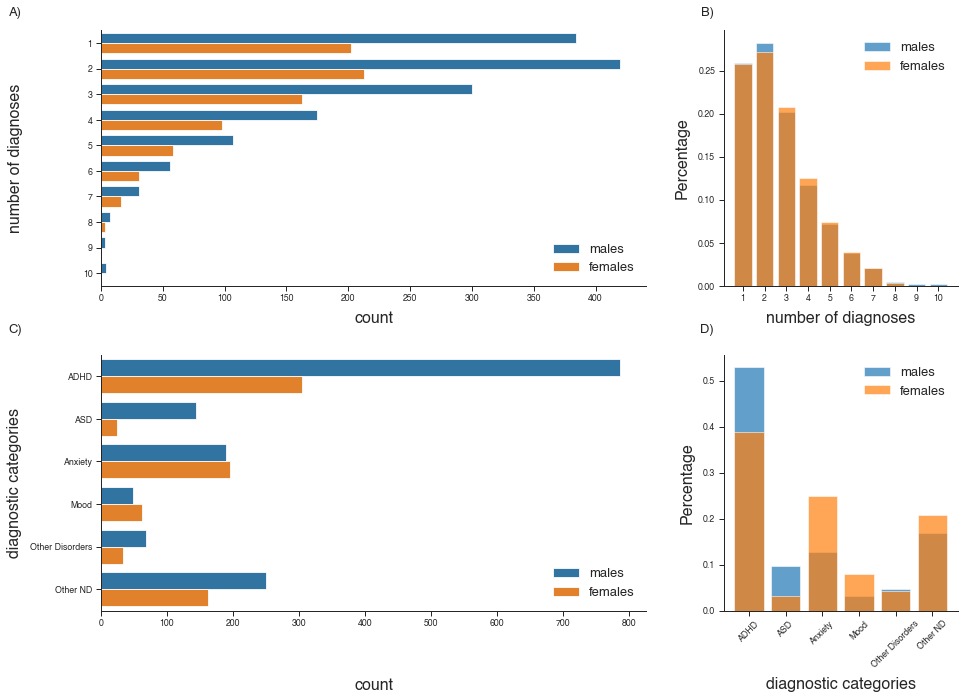

In [473]:
ax_mosaic = plt.figure(figsize=(14,10)).subplot_mosaic(
    """
    AAB
    CCD
    """
)

count = sns.countplot(data=demos, hue="Sex", y="summed", hue_order=[0, 1], ax=ax_mosaic["A"], palette="tab10")

handles, labels  =  count.get_legend_handles_labels()
count.legend(handles, ['males', 'females'], loc='lower right', frameon=False, fontsize=13)

count.set_xlabel('count',fontsize=16, labelpad=8)
count.set_ylabel('number of diagnoses',fontsize=16, labelpad=60)
count.set_yticklabels(np.arange(1,11))


#####


grouped_data = demos.groupby("Sex").summed.value_counts(normalize=True, sort=False)
bins = np.arange(12) - 0.5

# iterate over the groups
for group_name, group_data in grouped_data.groupby(level=0):
    # extract the summed values and their frequencies
    x = group_data.index.get_level_values(1)
    y = group_data.values
    
    # plot a barplot for each group
    ax_mosaic["B"].bar(x, height=y, alpha=0.7)


# add axis labels and a legend
ax_mosaic["B"].set_xlabel("number of diagnoses", fontsize=16, labelpad=8)
ax_mosaic["B"].set_ylabel("Percentage", fontsize=16, labelpad=8)
ax_mosaic["B"].set_xticks(np.arange(1, 11, 1))
#ax_mosaic["B"].set_xlim([0, 11])
ax_mosaic["B"].legend(labels=["males", "females"], loc='upper right', frameon=False, fontsize=13)



##### categories ### 

grouped_data = tt.groupby("Sex").DX_cat_new.value_counts(normalize=True, sort=False)
#bins = np.arange(12) - 0.5

# iterate over the groups
for group_name, group_data in grouped_data.groupby(level=0):
    # extract the summed values and their frequencies
    x = group_data.index.get_level_values(1)
    y = group_data.values
    
    # plot a histogram for each group
    ax_mosaic["D"].bar(x, height=y, alpha=0.7)


# add axis labels and a legend
ax_mosaic["D"].set_xlabel("diagnostic categories", fontsize=16, labelpad=8)
ax_mosaic["D"].set_ylabel("Percentage", fontsize=16, labelpad=8)
ax_mosaic["D"].legend(labels=["males", "females"], loc='upper right', frameon=False, fontsize=13)

ax_mosaic["D"].set_xticklabels(x, rotation=45)



count_cat = sns.countplot(data=tt, hue="Sex", y="DX_cat_new", hue_order=[0, 1], ax=ax_mosaic["C"], palette="tab10", order=x) #note: using x from the barplots is a bit hacky

handles, labels  =  count_cat.get_legend_handles_labels()
count_cat.legend(handles, ['males', 'females'], loc='lower right', frameon=False, fontsize=13)

count_cat.set_xlabel('count',fontsize=16, labelpad=50)
#count_cat.set_yticklabels(count_cat.get_yticklabels(), rotation=30)

count_cat.set_ylabel('diagnostic categories',fontsize=16, labelpad=8)


plt.figtext(0.03,0.98,"A)",ha="left",size=13)
plt.figtext(0.73,0.98,"B)",ha="right",size=13)

plt.figtext(0.03,0.54,"C)",ha="left",size=13)
plt.figtext(0.73,0.54,"D)",ha="right",size=13)

plt.tight_layout(pad=3)
sns.despine()


#plt.savefig("HBN_psychopath_dist.svg", bbox_inches='tight')




### cbcl 

In [474]:
# load cbcl information from COINS
# change path to file
cbcl = pd.read_csv("9994_CBCL_20220818.csv", skiprows=[1],
                   usecols=["CBCL_Int", "CBCL_Ext", "CBCL_Total", "EID"])

cbcl.rename(columns={"EID": "subjectkey"}, inplace=True)
cbcl["subjectkey"] = [
        "sub-" + x for x in cbcl["subjectkey"]]


In [316]:
## combine demos and predicted embedding
hbn = dic["demos"][1] 
hbn["prediction"] = np.squeeze(dic["predictions"]) # predicted embedding
hbn.rename(columns={"Identifiers":"subjectkey"},inplace=True)

### exclude first subject since it was err. not excluded ### 
hbn = hbn.loc[~hbn["DX_01"].isin(
            ["No Diagnosis Given", "No Diagnosis Given: Incomplete Eval"]
        )]
hbn.shape

(2271, 16)

## get puberty information

#### Note: we use data from LORIS + COINS releases to make sure to gather every available data 

- The first cells contain some data handling to align both datasets and eventually combine them 





In [317]:
### specify puberty columns for loris
pub_cols = ['PPS,PPS_F_01',
 'PPS,PPS_F_02',
 'PPS,PPS_F_03',
 'PPS,PPS_F_04','PPS,PPS_F_05',
 'PPS,PPS_F_06', "PPS,PPS_F_Score",
'PPS,PPS_M_01',
 'PPS,PPS_M_02',
 'PPS,PPS_M_03',
 'PPS,PPS_M_04',
 'PPS,PPS_M_05',
'PPS,PPS_M_06',
           "PPS,PPS_M_Score"]

In [318]:
loris_pub=pd.read_csv('../../hbn/nonMRI/HBN_Petersen_neu1708.csv', sep = ',', skiprows=[1],
                usecols= pub_cols + ["Identifiers"])
                   # read header
    
loris_pub["Identifiers"] = ["sub-"+ x for x in loris_pub["Identifiers"]]
loris_pub["Identifiers"] =loris_pub["Identifiers"].str.replace(',assessment', '')
loris_pub.drop_duplicates(subset=["Identifiers"], inplace=True)

loris_pub.shape

(2842, 15)

In [319]:
### different column naming between loris and coins file 
col_map = [x.replace('PPS,', '') for x in loris_pub.columns if x.startswith("PPS")]
col_to_map = [x for x in loris_pub.columns if x.startswith("PPS")]
mapper_dic = dict(zip(col_to_map, col_map))
mapper_dic


## map loris column names to coin column names

{'PPS,PPS_F_01': 'PPS_F_01',
 'PPS,PPS_F_02': 'PPS_F_02',
 'PPS,PPS_F_03': 'PPS_F_03',
 'PPS,PPS_F_04': 'PPS_F_04',
 'PPS,PPS_F_05': 'PPS_F_05',
 'PPS,PPS_F_06': 'PPS_F_06',
 'PPS,PPS_F_Score': 'PPS_F_Score',
 'PPS,PPS_M_01': 'PPS_M_01',
 'PPS,PPS_M_02': 'PPS_M_02',
 'PPS,PPS_M_03': 'PPS_M_03',
 'PPS,PPS_M_04': 'PPS_M_04',
 'PPS,PPS_M_05': 'PPS_M_05',
 'PPS,PPS_M_06': 'PPS_M_06',
 'PPS,PPS_M_Score': 'PPS_M_Score'}

In [320]:
loris_pub.rename(mapper=mapper_dic, axis=1, inplace=True)
loris_pub.rename(columns={"Identifiers":"subjectkey"},inplace=True)
loris_pub[col_map] = loris_pub[col_map].replace('.', np.nan)
loris_pub[col_map] = loris_pub[col_map].astype("float64")


In [321]:
### COINS ###

coins_pub = pd.read_csv("../../hbn/nonMRI/coins/assessment_data/9994_PPS_20220818.csv",
                      sep = ',', skiprows=[1])


coins_pub["subjectkey"] = ["sub-"+ x for x in coins_pub["EID"]] ### note: in loris file, variables are labeled differently

coins_pub["subjectkey"] =coins_pub["subjectkey"].str.replace(',assessment', '')

coins_pub.drop_duplicates(subset=["subjectkey"], inplace=True)

coins_pub = coins_pub[["subjectkey"]+col_map]
coins_pub.shape



(2450, 15)

In [322]:
pub_combined = pd.concat([coins_pub, loris_pub]) # concat both loris and coins
print(pub_combined.shape)
pub_combined.drop_duplicates(subset="subjectkey", inplace=True) # drop duplicates
print(pub_combined.shape)


(5292, 15)
(2843, 15)


In [323]:
pub_d = pd.merge(hbn, pub_combined, on="subjectkey") #merge embedding info and puberty info
pub_d.drop_duplicates(subset="subjectkey", inplace=True)
pub_d.shape

(1708, 30)

## Association Analyses




### get puberty information

#### puberty information in analogy to ABCD sample

In [324]:
fem = pub_d.loc[pub_d["Sex"]==1] ## subset for sex
men = pub_d.loc[pub_d["Sex"]==0]


## calculate gonadal puberty scores 
fem["gonadal"]= fem[["PPS_F_01", "PPS_F_04", "PPS_F_06"]].mean(axis=1, skipna=False)
men["gonadal"] = men[["PPS_M_01","PPS_M_04", "PPS_M_05"]].mean(axis=1, skipna=False)


## calculate adrenal puberty scores
fem["adrenal"]= fem[["PPS_F_02", "PPS_F_03"]].mean(axis=1, skipna=False)
men["adrenal"]= men[["PPS_M_02", "PPS_M_03"]].mean(axis=1, skipna=False)

## calculate average PDS scores
fem["PDS_mean"] =  fem[['PPS_F_01',
 'PPS_F_02',
 'PPS_F_03',
 'PPS_F_04',
 'PPS_F_06',]].mean(axis=1, skipna=False)
men["PDS_mean"] =  men[['PPS_M_01',
 'PPS_M_02',
 'PPS_M_03',
 'PPS_M_04',
 'PPS_M_05']].mean(axis=1, skipna=False)

## calculate PDS category score
fem["PDS_cat_score"] = fem[["PPS_F_02", "PPS_F_04"]].sum(axis=1, skipna=False) ##### error f2 statt f1 ### 
men["PDS_cat_score"] = men[["PPS_M_02","PPS_M_04", "PPS_M_05"]].sum(axis=1, skipna=False)

In [325]:
def female_categorical(row):
    '''
    female: body hair growth + breast development || using menarche info as follows:
    prepubertal = 2 + no menarche
    early pubertal = 3 + no menarche
    midpubertal =>3 + no menarche
    late pubertal <=7 + menarche
    postpubertal = 8 + menarche
    according to Herting et al (2021) Frontiers in Endocrinology
    '''
    if np.isnan(row["PDS_cat_score"])==False:
        
        if row["PPS_F_06"] == 0.0: #no
            if row["PDS_cat_score"] == 2.0:
                return "prepubertal"
            if row["PDS_cat_score"] == 3.0:
                return "early pubertal"
            if row["PDS_cat_score"] >= 3.0:
                return "midpubertal"
            
        elif row["PPS_F_06"] == 1.0: #yes
            if row["PDS_cat_score"] <= 7.0:
                return "late pubertal"
            if row["PDS_cat_score"] == 8.0:
                return "postpubertal"
                  
    elif np.isnan(row["PDS_cat_score"])==True:
        return np.nan
    
    
def male_categorical(row):
    '''
    male: body hair growth + facial hair + voice change
    prepubertal = 3 x
    early pubertal = 4 or 5 (no 3 point response)x
    midpubertal = 6-8 (no point 4 response) x
    late pubertal = 9-11 
    postpubertal = 12 (all 4 point)
    according to Herting et al (2021) Frontiers in Endocrinology
    with minor adjustment to not create cases for which category is not
    well defined (see paper)
    '''
    if np.isnan(row["PDS_cat_score"])==False:
        
        if row["PDS_cat_score"] == 3.0:
            return "prepubertal"
        
        if 4.0 <= row["PDS_cat_score"] <= 5.0:
            return "early pubertal"
            
        if 6.0 <= row["PDS_cat_score"] <= 8.0:
            return "midpubertal"
            
        if 9.0 <= row["PDS_cat_score"] <= 11.0:
                return "late pubertal"
            
        if row["PDS_cat_score"] == 12.0:
            return "postpubertal"
        
    elif np.isnan(row["PDS_cat_score"])==True:
        return np.nan

In [326]:
fem["PDS_category"] = fem.apply(lambda row: female_categorical(row), axis=1)
men["PDS_category"] = men.apply(lambda row: male_categorical(row), axis=1)

pub_all = pd.concat([fem, men])
pub_all.shape

(1708, 35)

In [327]:
tmp1 = pub_all.copy() # copy dataframe 

### Psychopathology Model


In [450]:
psycho_models = [
    'prediction ~ summed + Age + C(Scan_Location)'] # with sum of diagnoses
    

for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in psycho_models:
        
        
        model = smf.ols(formula=m, data=hbn.loc[hbn["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")
        


MALE
prediction ~ summed + Age + C(Scan_Location)
1487
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2066      0.136      1.513      0.130      -0.061       0.474
C(Scan_Location)[T.2]     0.0725      0.104      0.700      0.484      -0.131       0.276
C(Scan_Location)[T.3]     0.1016      0.103      0.985      0.325      -0.101       0.304
C(Scan_Location)[T.4]     0.0458      0.148      0.310      0.756      -0.244       0.335
summed                    0.0368      0.019      1.953      0.051      -0.000       0.074
Age                      -0.0512      0.009     -5.757      0.000      -0.069      -0.034
0.03676619062281872 0.05096931434786059
-0.051209360474663464 1.038120489674711e-08


Partial eta squared for summed: 0.00097
Partial eta squared for Age: 0.02189
----------------


FEMALE
prediction ~ summed + Age + C(Scan_L

In [338]:
check = hbn.merge(cbcl, on="subjectkey", how="left") ### 367 NaN in CBCL variables 

subjectkey          0
Age                 0
Sex                 0
Scan_Location       0
DX_01               0
DX_02             586
DX_03            1219
DX_04            1682
DX_05            1955
DX_06            2120
DX_07            2207
DX_08            2254
DX_09            2264
DX_10            2267
summed              0
prediction          0
CBCL_Int          367
CBCL_Ext          367
CBCL_Total        367
dtype: int64

In [343]:
### note: for summed, the dataframe doesnt need to be merged with puberty info, thus leaving more subjects for the association, since there are no NaN in sum
psycho_models = [
    'prediction ~ CBCL_Total + Age + C(Scan_Location)'] #change to summed
    

for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in psycho_models:
        
        
        model = smf.ols(formula=m, data=check.loc[check["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")
        


MALE
prediction ~ CBCL_Total + Age + C(Scan_Location)
1269
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1170      0.159      0.736      0.462      -0.195       0.429
C(Scan_Location)[T.2]     0.1395      0.106      1.311      0.190      -0.069       0.348
C(Scan_Location)[T.3]     0.1966      0.107      1.840      0.066      -0.013       0.406
C(Scan_Location)[T.4]     0.0372      0.182      0.204      0.838      -0.321       0.395
CBCL_Total                0.0023      0.001      1.861      0.063      -0.000       0.005
Age                      -0.0514      0.010     -5.017      0.000      -0.072      -0.031
0.002306516652907232 0.06299436171298856
-0.05144896078628928 5.984589717906963e-07


Partial eta squared for CBCL_Total: 0.00371
Partial eta squared for Age: 0.01954
----------------


FEMALE
prediction ~ CBCL_Total + Ag

In [440]:
### corr summed + cbcl total
check_nona= check.dropna(subset=["CBCL_Total"])
stats.spearmanr(check_nona.summed, check_nona.CBCL_Total)

SpearmanrResult(correlation=0.3186743247477985, pvalue=3.3737915122689e-46)

In [354]:

### merging cbcl and puberty info ### 
tmp2 = tmp1.merge(cbcl, on="subjectkey", how="left")

In [346]:
psycho_pub_models = [
    'prediction ~ PDS_mean + CBCL_Total + Age + C(Scan_Location)',
    'prediction ~ PDS_mean + CBCL_Total + CBCL_Total:PDS_mean + Age + C(Scan_Location)']

for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in psycho_pub_models:
        
        
        model = smf.ols(formula=m, data=tmp2.loc[tmp2["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")

MALE
prediction ~ PDS_mean + CBCL_Total + Age + C(Scan_Location)
943
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2218      0.217      1.021      0.307      -0.204       0.648
C(Scan_Location)[T.2]     0.0911      0.168      0.544      0.587      -0.238       0.420
C(Scan_Location)[T.3]     0.1443      0.168      0.857      0.392      -0.186       0.475
C(Scan_Location)[T.4]     0.1265      0.250      0.507      0.613      -0.364       0.617
PDS_mean                 -0.0120      0.081     -0.148      0.882      -0.171       0.147
CBCL_Total                0.0013      0.001      0.881      0.378      -0.002       0.004
Age                      -0.0496      0.020     -2.468      0.014      -0.089      -0.010
0.0012700998845435719 0.3782884918765608
-0.04957946288269076 0.01374697980715516


Partial eta squared for PDS_mean: 0.0

In [335]:
psycho_pub_models = [
    'prediction ~ PDS_mean + summed + Age + C(Scan_Location)',
    'prediction ~ PDS_mean + summed + summed:PDS_mean + Age + C(Scan_Location)']

for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in psycho_pub_models:
        
        
        model = smf.ols(formula=m, data=tmp1.loc[tmp1["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")
        


MALE
prediction ~ PDS_mean + summed + Age + C(Scan_Location)
1105
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2360      0.198      1.194      0.233      -0.152       0.624
C(Scan_Location)[T.2]     0.0582      0.166      0.351      0.726      -0.267       0.384
C(Scan_Location)[T.3]     0.0764      0.166      0.460      0.646      -0.250       0.402
C(Scan_Location)[T.4]     0.0577      0.206      0.280      0.780      -0.347       0.462
PDS_mean                  0.0512      0.076      0.676      0.499      -0.097       0.200
summed                    0.0366      0.022      1.643      0.101      -0.007       0.080
Age                      -0.0610      0.018     -3.367      0.001      -0.096      -0.025
0.036601144170140536 0.1006688485146742
-0.06095264591122897 0.0007875923423229345


Partial eta squared for PDS_mean: 0.010

#### puberty models for HBN with restricted subsamples that match the cross-sectional age ranges in ABCD base and follow 

In [394]:
## age ranges for cross-sectional ABCD associations
base_min_age = 8.916666666666666
base_max_age = 11.083333333333334

follow_min_age = 10.583333333333334
follow_max_age = 13.833333333333334

In [399]:
pub_models = [
    'prediction ~ PDS_mean + Age + C(Scan_Location)']


for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in pub_models:
        
        
        model = smf.ols(formula=m, data=tmp1[tmp1.Age.between(base_min_age, base_max_age)].loc[tmp1["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")
        
###restricted for baseline ABCD age

MALE
prediction ~ PDS_mean + Age + C(Scan_Location)
300
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.9946      1.093     -1.824      0.069      -4.147       0.157
C(Scan_Location)[T.2]    -0.5132      0.321     -1.597      0.111      -1.146       0.119
C(Scan_Location)[T.3]    -0.1026      0.323     -0.317      0.751      -0.738       0.533
C(Scan_Location)[T.4]    -0.3773      0.367     -1.027      0.305      -1.100       0.346
PDS_mean                  0.0660      0.157      0.419      0.675      -0.244       0.376
Age                       0.2022      0.109      1.848      0.066      -0.013       0.418
0.06604194640969738 0.6752679223329507
0.20219229006638423 0.06559948662597727


Partial eta squared for PDS_mean: 0.00341
Partial eta squared for Age: 0.01148
----------------


FEMALE
prediction ~ PDS_mean + Age + C(Scan_L

In [400]:
pub_models = [
    'prediction ~ PDS_mean + Age + C(Scan_Location)']


for s in [0,1]:
    if s == 0:
        print("MALE")
    elif s == 1:
        print("FEMALE")
    
    for m in pub_models:
        
        
        model = smf.ols(formula=m, data=tmp1[tmp1.Age.between(follow_min_age, follow_max_age)].loc[tmp1["Sex"]==s]).fit()
        summary = model.summary()

        print(m)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("----------------")
        print("\n")
        


MALE
prediction ~ PDS_mean + Age + C(Scan_Location)
259
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.6146      1.083      2.413      0.017       0.481       4.748
C(Scan_Location)[T.2]    -0.6076      0.386     -1.574      0.117      -1.368       0.153
C(Scan_Location)[T.3]    -0.4252      0.385     -1.105      0.270      -1.183       0.333
C(Scan_Location)[T.4]    -0.7026      0.493     -1.424      0.156      -1.674       0.269
PDS_mean                 -0.1229      0.136     -0.905      0.366      -0.390       0.145
Age                      -0.1694      0.092     -1.837      0.067      -0.351       0.012
-0.12294214323165023 0.3662132905999904
-0.16942826047484055 0.06739733816879288


Partial eta squared for PDS_mean: 0.01482
Partial eta squared for Age: 0.01316
----------------


FEMALE
prediction ~ PDS_mean + Age + C(Scan